# Practical 4 Part 3 - Selective Neural Style Transfer

In this final section, we will be combining both Image Segmentation and Neural Style Transfer to paint a new style over a person's clothing. 

1. Our Image Segmentation model takes in Image1 (the image of a person) and produces SegMap, an segmentation map.
2. Our Neural Style transfer takes in Image1, and Image2 (the style image) performs a neural style transfer to generate Image3.
3. The last part will generate Image4, copying pixels from Image3 or Image1, depending on the corresponding classified pixel in SegMap.




### 4.3.1 Logging On To Google Drive.

To connect to Google Drive:

1. Run the cell below.
2. Click on the link provided and sign in with your Google Account.
3. Copy the authorization code and paste it in the prompt below, and then press Enter.

In [1]:
# Run this if you are using Google Drive
#
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## 4.3.2 Initialization Our Functions

The following section initializes everything that we need to run segmentation on an image. 


In [2]:
# Run this code as is.
#
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt

import cv2
from scipy.optimize import fmin_l_bfgs_b
import time
import argparse

import matplotlib.pyplot as plt

from tensorflow.keras.applications import vgg19
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

import os

os.environ['SM_FRAMEWORK'] = "tf.keras"

!pip install git+https://github.com/qubvel/segmentation_models

import segmentation_models as sm

#-----------------------------------------------------------------------
# Important variables for initialization
#-----------------------------------------------------------------------

folder = '/content/drive/My Drive/Data/D4/'
segmentation_model_path = folder + 'segmentation_model.h5'
segmentation_backbone = 'resnet34'

# Image size
width = 192
height = 288

#-----------------------------------------------------------------------
# Load our segmentation model
#-----------------------------------------------------------------------

print ('Loading segmentation model...')
segmentation_model = load_model(segmentation_model_path, 
                   custom_objects={"focal_loss_plus_jaccard_loss": sm.losses.categorical_focal_jaccard_loss, 
                                  'iou_score': sm.metrics.iou_score})
preprocess_input = sm.get_preprocessing(segmentation_backbone)

#-----------------------------------------------------------------------
# Some interface functions that allow us to load and resize image.
#-----------------------------------------------------------------------

# Loads an image using OpenCV and returns the result
# in a numpy array in R, G, B order.
#
def loadimage(filename):
    img = cv2.imread(filename)
    img = img[...,::-1]     #reverse the RGB
    return img

# Resizes an image using OpenCV and returns the result
# in a numpy array in R, G, B order.
#
def resizeimage(img, width, height, nearest):
    if nearest:
        return cv2.resize(img, (width, height), interpolation=cv2.INTER_NEAREST)
    else:
        return cv2.resize(img, (width, height), interpolation=cv2.INTER_CUBIC)



  

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-r31yzmty
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-r31yzmty
  Running command git submodule update --init --recursive -q
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-cp36-none-any.whl size=33587 sha256=409721d0c47d828e29674abc90c62bcb3d374328c15a7409b0ff19d72e9cd0fc
  Stored in directory: /tmp/pip-ephem-wheel-cache-sp17xf9b/wheels/49/cf/46/cbb4bb64518c402aea99df9d466f1081450597e653256bbcf4
Successfully built segmentation-models
Segmentation Models: using `tf.keras` framework.
Loading segmentation model...
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of pa

## 4.3.3 Performing the Segmented Neural Style Transfer

The codes for performing the segmentation and neural style transfer are found in the cell below. Take a look at the code and try to get an idea of what it is trying to achieve.

*Note: The neural style transfer are performed on an image of 384x576, while the segmentation is performed on an image of 192x288 (half width/half height).*


In [0]:
#-----------------------------------------------------------------------
# The following is referenced and adapted from:
#   https://keras.io/examples/neural_style_transfer/
#-----------------------------------------------------------------------

# Run this whole section of code as is.
#
# if start from the base image:
#
initial_random = False
total_variation_weight = 1.0
style_weight = 1.0
content_weight = 0.1

scale = 2

img_nrows = 288 * scale
img_ncols = 192 * scale

# util function to open, resize and format pictures into appropriate tensors
#
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = resizeimage(img, img_ncols, img_nrows, False)
    #img = loadimage(image_path)
    #img = resizeimage(img, img_ncols, img_nrows, False)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

# util function to convert a tensor into a valid image
#
def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, img_nrows, img_ncols))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x




# compute the neural style loss
# first we need to define 4 util functions

# the gram matrix of an image tensor (feature-wise outer product)
#
def gram_matrix(x):
    assert K.ndim(x) == 3
    if K.image_data_format() == 'channels_first':
        features = K.batch_flatten(x)
    else:
        features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

# the "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image
#
def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

# an auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image
#
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

# the 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent
#
def total_variation_loss(x):
    assert K.ndim(x) == 4
    if K.image_data_format() == 'channels_first':
        a = K.square(
            x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, 1:, :img_ncols - 1])
        b = K.square(
            x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, :img_nrows - 1, 1:])
    else:
        a = K.square(
            x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
        b = K.square(
            x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))




def eval_loss_and_grads(x, f_outputs):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((1, 3, img_nrows, img_ncols))
    else:
        x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

# this Evaluator class makes it possible
# to compute loss and gradients in one pass
# while retrieving them via two separate functions,
# "loss" and "grads". This is done because scipy.optimize
# requires separate functions for loss and gradients,
# but computing them separately would be inefficient.
#
class Evaluator(object):

    def __init__(self, f_outputs):
        self.loss_value = None
        self.grads_values = None
        self.f_outputs = f_outputs

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x, self.f_outputs)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values


def perform_neural_transfer(base_image_path, style_reference_image_path, iterations):

    # get tensor representations of our images
    base_image = K.variable(preprocess_image(base_image_path))
    style_reference_image = K.variable(preprocess_image(style_reference_image_path))

    # this will contain our generated image
    if K.image_data_format() == 'channels_first':
        combination_image = K.placeholder((1, 3, img_nrows, img_ncols))
    else:
        combination_image = K.placeholder((1, img_nrows, img_ncols, 3))

    # combine the 3 images into a single Keras tensor
    input_tensor = K.concatenate([base_image,
                                  style_reference_image,
                                  combination_image], axis=0)

    # build the VGG19 network with our 3 images as input
    # the model will be loaded with pre-trained ImageNet weights
    model = vgg19.VGG19(input_tensor=input_tensor,
                        weights='imagenet', include_top=False)
    print('Model loaded.')

    # get the symbolic outputs of each "key" layer (we gave them unique names).
    outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

    # combine these loss functions into a single scalar
    #
    loss = K.variable(0.0)
    layer_features = outputs_dict['block5_conv2']
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(base_image_features,
                                                combination_features)

    feature_layers = ['block1_conv1', 'block2_conv1',
                      'block3_conv1', 'block4_conv1',
                      'block5_conv1']
    for layer_name in feature_layers:
        layer_features = outputs_dict[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss = loss + (style_weight / len(feature_layers)) * sl
    loss = loss + total_variation_weight * total_variation_loss(combination_image)

    # get the gradients of the generated image wrt the loss
    #
    grads = K.gradients(loss, combination_image)

    outputs = [loss]
    if isinstance(grads, (list, tuple)):
        outputs += grads
    else:
        outputs.append(grads)

    f_outputs = K.function([combination_image], outputs)

    # We either load the original image file, or start with a totally
    # random image.
    #
    if initial_random:
        x = np.random.rand(1, height * scale, width * scale, 3)
    else:
        x = preprocess_image(base_image_path)

    # run scipy-based optimization (L-BFGS) over the pixels of the generated image
    # so as to minimize the neural style loss.
    #
    evaluator = Evaluator(f_outputs)
    for i in range(iterations):
        print('  Iteration %d started...' % (i))
        start_time = time.time()
        x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                        fprime=evaluator.grads, maxfun=20)

        # save current generated image
        curimg = deprocess_image(x.copy())
        fname = folder + ('output_full_%d.png' % (i))
        cv2.imwrite(fname, curimg)

        fullstyledimg = curimg[...,::-1]
        end_time = time.time()
        
        print('  Iteration %d completed in %ds (loss = %f)' % (i, end_time - start_time, min_val))  

    return fullstyledimg



## 4.3.4 Method to Perform the Selective Transfer.

The following method performs selective transfer in a few steps:
1. Load the base image.
2. Segment the base image to produce the segment map.
3. Perform the neural style transfer on base image + style image to produce the full-styled imaged
4. Transfer part of the full-styled image back to the base image, but only if the pixel on the segment map is not classified as the background.

To do the merge in step 4, we have to loop through the segmentation map and individual pixels in the base and the style-transferred image, and choose the appropriate pixel to form our final image.


In [0]:
# This method allows us to perform a selective style 
# transfer given a base and style image.
#
def perform_selective_transfer(base_image_path, style_reference_image_path):

    print ("Starting selective style transfer...")
    #-----------------------------------------------------------------------
    # 1. Load image.
    #-----------------------------------------------------------------------

    # Load up the image in RGB format and resize it
    #
    print ("Loading base image...")
    img = loadimage(base_image_path)
    imgx = resizeimage(img, width * scale, height * scale, False)  # Bicubic interpolation
    img = resizeimage(img, width, height, False)                   # Bicubic interpolation

    print ("Loading done...")


    #-----------------------------------------------------------------------
    # 2. Perform the image segmentation here
    #-----------------------------------------------------------------------

    print ("Segmenting image...")

    # Convert the image into our Keras tensor and
    # preprocess it according to the VGG19 requirements
    #
    imgproc = img.reshape(1, height, width, img.shape[2])
    imgproc = preprocess_input(imgproc)

    # Segment our image and identify which pixels
    # are the clothing apparel and which are not.
    #
    segmentation = segmentation_model.predict(imgproc)
    segmentation = segmentation.reshape(width * height, segmentation.shape[3])
    segmentation = list(map(lambda x: np.argmax(x, axis=0) , segmentation))
    segmentation = np.array(segmentation).reshape(height, width, 1)

    segmentation = resizeimage(segmentation, width * scale, height * scale, True)
    #print (segmentation.shape)

    print ("Segmenting done.")

    #-----------------------------------------------------------------------
    # 3. Perform the neural style transfer
    #-----------------------------------------------------------------------

    print ("Performing neural style transfer...")

    # You can change the number of iterations
    fullstyledimg = perform_neural_transfer(base_image_path, style_reference_image_path, 15)

    print ("Performing neural style transfer done...")
    
    #-----------------------------------------------------------------------
    # 4. Merge the neural transfer results into our image but only
    #    on the pixels that are classified as apparel.
    #-----------------------------------------------------------------------

    partstyledimg = np.zeros((height * scale, width * scale, 3), dtype=np.uint8)
    
    # TODO:
    # Merge the transferred style with the original base image, but
    # transfer only those pixels that are classified as non-background.
    #
    #...#
    for y in range(0, height * scale):
        for x in range(0, width * scale):
            # This is where we merge the original and the style transfered image
            #
            if segmentation[y, x] == 0:
                partstyledimg[y,x] = imgx[y,x]
            else:
                partstyledimg[y,x] = fullstyledimg[y,x]
    
    #-----------------------------------------------------------------------
    # 5. Plot the images in Notebook
    #-----------------------------------------------------------------------
    
    plt.figure(figsize=(20,28))
    ax = plt.subplot(1, 4, 1)
    ax.set_title("original")
    plt.imshow(imgx)

    ax = plt.subplot(1, 4, 2)
    ax.set_title("segmentation")
    plt.imshow(segmentation)

    ax = plt.subplot(1, 4, 3)
    ax.set_title("full style-transfer")
    plt.imshow(fullstyledimg)

    ax = plt.subplot(1, 4, 4)
    ax.set_title("segmented style-transfer")
    plt.imshow(partstyledimg)

    plt.show()
    
    #return imgx, segmentation, partstyledimg


## 4.3.5 Performing the Style Transfer

Finally, let's perform the selective style transfer. First we will have to upload two files into directly into Google Colab's temporary drive. We can do this by calling the following function:

```
    uploaded = files.upload()
```

This opens a prompt to upload a file. Once uploaded, you can retrieve path of the file uploaded and send it to the perform the selective style transfer.

Run the following cell as is.


Upload the base image


Saving 2098.jpg to 2098 (1).jpg
You uploaded file "2098.jpg" with length 54322 bytes
Upload the style image


Saving 1.jpg to 1.jpg
You uploaded file "1.jpg" with length 884624 bytes
Starting selective style transfer...
Loading base image...
Loading done...
Segmenting image...
Segmenting done.
Performing neural style transfer...
80142336/80134624 [==============================] - 1s 0us/step
Model loaded.
  Iteration 0 started...
  Iteration 0 completed in 10s (loss = 7219026944.000000)
  Iteration 1 started...
  Iteration 1 completed in 6s (loss = 5384436736.000000)
  Iteration 2 started...
  Iteration 2 completed in 6s (loss = 4889372672.000000)
  Iteration 3 started...
  Iteration 3 completed in 6s (loss = 4575937024.000000)
  Iteration 4 started...
  Iteration 4 completed in 6s (loss = 4436633600.000000)
  Iteration 5 started...
  Iteration 5 completed in 6s (loss = 4333203456.000000)
  Iteration 6 started...
  Iteration 6 completed in 6s (loss = 4244965120.000000)
  Iteration 7 started...
  Iteration 7 completed in 6s (loss = 4182607872.000000)
  Iteration 8 started...
  Iteration 8 comp

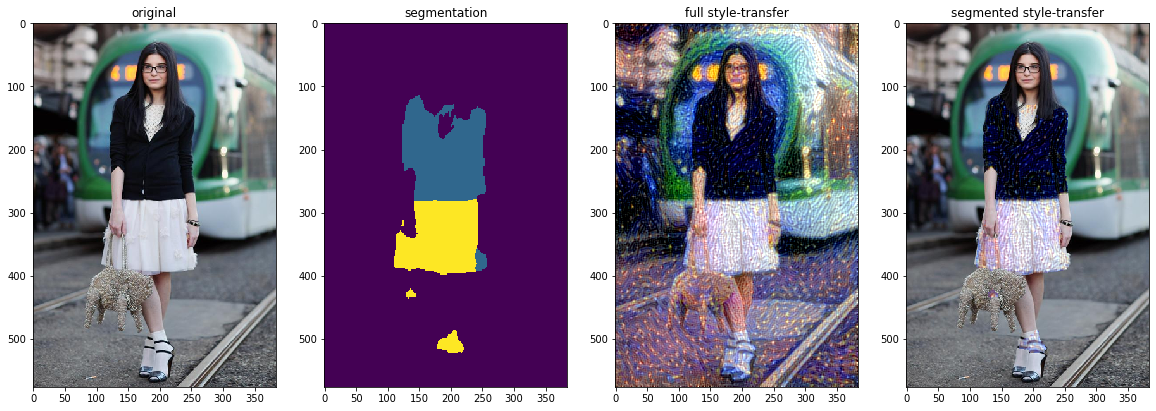

In [6]:
# Prompt the user of this Notebook to upload the base image.
#
from google.colab import files
print ("Upload the base image")
uploaded = files.upload()
for fn in uploaded.keys():
    print('You uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))
    base_image_path = fn
    break

# Prompt the user of this Notebook to upload the style image.
#
print ("Upload the style image")
uploaded = files.upload()
for fn in uploaded.keys():
    print('You uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))
    style_reference_image_path = fn
    break

# Call our method to perform the selective style transfer.
#
perform_selective_transfer(base_image_path, style_reference_image_path)



## 4.3.6 Challenge

Try hosting this entire process using Flask.


Your Flask application should accept a POST request via http://localhost:5005/styletransfer. It should accept two files and perform the selective style transfer. Once the style transfer is complete, save the resulting image into your application folder.

Finally, use Postman to connect to your POST API to test.

*NOTE: For practicality, set a lower number of iterations according to the power of your GPU.*